# Predicting Learner Completion Time to Enable Early Intervention

## Project Introduction

**Business Question:**  
Can we accurately predict which apprentices are likely to complete on time or overrun their expected programme duration?

**Impact:**  
- Earlier intervention for at-risk learners
- Better capacity planning
- Improved funding forecasting
- Reduced dropout risk

**Approach:**  
This project follows an end-to-end modelling workflow:
- Exploratory data analysis
- Data cleaning and feature engineering
- Regression modelling
- Classification modelling
- Model evaluation and interpretation

**Data Source & Privacy Considerations:**  

- This project uses real apprenticeship programme data from my organisation.  
- All PII has been removed or anonymised.
- Categorical variables (e.g., apprenticeship titles) have been retained only where necessary for modelling purposes and do not expose sensitive individual information.
- The analysis focuses on aggregated behavioural, demographic, and programme-level features engineered from operational data.  
- This ensures that the project reflects real-world modelling challenges while maintaining appropriate data privacy standards.


## Executive Summary

### From Duration Prediction to Early Risk Classification

This project investigated whether early learner and engagement data can be used to predict apprenticeship completion patterns and support proactive intervention.

The target feature was `Days On Programme` which represents the number of days taken for a learner to complete their programme.

The original objective was to predict the target using demographic, programme, employer, and early behavioural data (first 90 days post-induction). However, regression modelling showed limited explanatory power, leading to a strategic reframing of the problem into a classification task focused on identifying learners at risk of extended completion.



### Phase 1: Regression Modelling

The initial approach treated programme duration as a continuous outcome.

Models evaluated:
- Linear Regression (baseline comparison)
- Random Forest Regressor
- Random Forest with log-transformed target

Key findings:

- Linear regression provided minimal improvement over the baseline, indicating non-linear relationships.
- Random Forest slightly improved performance, suggesting non-linear interactions in the data.
- Log transformation further improved MAE, confirming right-skewness in the target.
- Even with non-linear models, a maximum ~4% of variance was explained. This does not mean no predictive signal — just limited precision for continuous forecasting.

**Conclusion:**  
Exact prediction of the target is difficult with available features. The signal was present but not strong enough to support reliable operational forecasting.



### Phase 2: Reframing as a Classification Problem

Given the operational goal is intervention — not exact day prediction — the problem was reframed to:

"Can we identify learners likely to exceed the expected programme duration by 2 weeks?"

Using only data available within the first 90 days (to prevent time leakage), a Random Forest classifier was trained.

#### First Iteration (Basic Random Forest)

- Accuracy: **0.54**
- ROC AUC: **0.73**
- F1 Score: **0.60**
- Precision: **0.42**
- Recall: **0.90** for learners exceeding 380 days

While overall accuracy is modest, the model achieves strong recall which is what it was optimised for. It catches more positives but with more false alarms, since it is a greater operational cost for a learner to be delayed than to provide support for them.

#### Second Iteration (With Feature Engineering)

- Accuracy: **0.61**
- ROC AUC: **0.73**
- F1 Score: **0.59**
- Precision: **0.46**
- Recall: **0.84**

Additional behavioural aggregates improved performance further, confirming that early engagement intensity and progression metrics are strong predictors of prolonged completion.



### Key Insights

- Programme duration is influenced by non-linear, interaction-driven factors.
- Early behavioural engagement (projects, OTJ logging, activity levels) contains actionable predictive signal.
- Classification provides stronger business alignment than regression for intervention use cases.
- Restricting features to the first 90 days supports realistic deployment and avoids leakage.



### Business Implications

If deployed operationally, this model could:

- Flag learners at risk of extended completion within their first 90 days.
- Enable targeted early support interventions.
- Improve forecasting of delivery capacity and funding timelines.


### Demonstrated Capabilities

This project showcases:

- End-to-end data science workflow.
- Feature engineering with leakage awareness.
- Baseline comparison and model iteration.
- Regression & classification modelling.
- Model evaluation using appropriate metrics (ROC AUC, F1, Recall).
- Interpretation via feature importance analysis.
- Commercial awarenes and industry knowledge.

## EDA

### Load & Explore Data

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve,
    roc_curve, auc
)

In [75]:
df = pd.read_csv("Level3s.csv")

snapshot = pd.DataFrame({
    "Rows": [len(df)],
    "Columns": [df.shape[1]],
    "Missing cells (%)": [df.isna().mean().mean() * 100],
    "Duplicate rows": [df.duplicated().sum()],
    "Target missing (%)": [df["Days On Programme"].isna().mean() * 100],
    "Target mean": [df["Days On Programme"].mean()],
    "Target median": [df["Days On Programme"].median()],
}).round(2)

snapshot

,Rows,Columns,Missing cells (%),Duplicate rows,Target missing (%),Target mean,Target median
0,1396,14,6.83,0,0.0,391.23,373.0


The dataset is moderately sized and suitable for statistical modelling.

###Missingness Analysis

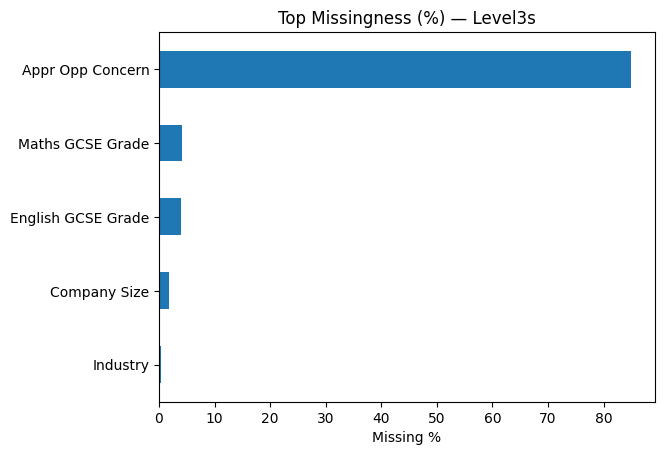

In [76]:
missing = df.isna().mean().sort_values(ascending=False) * 100
missing_top = missing.head(5).round(1).to_frame("Missing %")

missing_top.sort_values("Missing %").plot(kind="barh", legend=False)
plt.title("Top Missingness (%) — Level3s")
plt.xlabel("Missing %")
plt.show()

- `Appr Opp Concern` has ~85% missing values. This is because it is only be populated in exceptional cases (e.g., flagged learners).

- GCSE grades have relatively low missingness (~4%), suggesting they are mostly well recorded and may be strong predictors of completion or performance.

- Other features have minimal missing data and are suitable for modelling with light preprocessing.

###Check Duplicates

In [77]:
df.duplicated().sum()

np.int64(0)

###Target & Outlier analysis

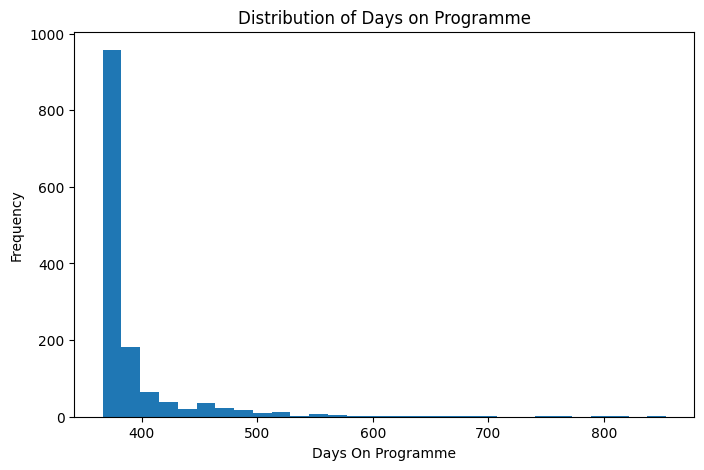

,Days On Programme
count,1396.0
mean,391.2
std,48.7
min,366.0
25%,369.0
50%,373.0
75%,387.0
max,854.0


In [78]:
plt.figure(figsize=(8,5))
plt.hist(df["Days On Programme"], bins=30)
plt.title("Distribution of Days on Programme")
plt.xlabel("Days On Programme")
plt.ylabel("Frequency")
plt.show()

df["Days On Programme"].describe().round(1)

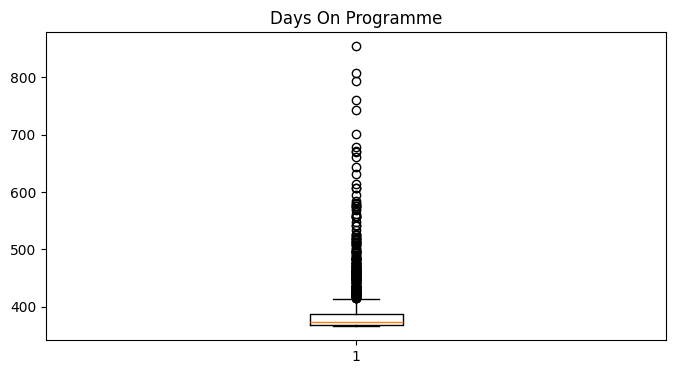

,0
IQR lower bound,342.00
IQR upper bound,414.00
Outliers (count),191.00
Outliers (%),13.68


In [79]:
x = df["Days On Programme"].dropna()

q1, q3 = x.quantile([0.25, 0.75])
iqr = q3 - q1
lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr

outlier_mask = (x < lb) | (x > ub)
outlier_pct = outlier_mask.mean() * 100

plt.figure(figsize=(8,4))
plt.boxplot(x)
plt.title("Days On Programme")
plt.show()

pd.Series({
    "IQR lower bound": lb,
    "IQR upper bound": ub,
    "Outliers (count)": int(outlier_mask.sum()),
    "Outliers (%)": outlier_pct
}).round(2)

The histogram and boxplot show that `Days on Programme` is heavily right-skewed.  
The majority of learners complete within a relatively tight range (366–380 days), while a substantial number of learners take significantly longer to complete.

Key observations:

- The interquartile range (IQR) is relatively narrow, since most learners complete within a predictable timeframe.
- There is a long upper tail with many extreme values (some exceeding 800 days).
- The large number of high-value outliers indicates that late completion is driven by a subset of learners with substantially extended durations.

This skewness has modelling implications:

- Linear regression may struggle due to non-normal residuals.
- Outliers can disproportionately influence error-based metrics such as RMSE.


Approximately 14% of learners are statistical outliers in programme duration. These may represent particularly long breaks in learning.

###Univariate Analysis

In EDA, every categorical column was plotted.

However, in the interest of reducing clutter, one focused plot for the most meaningful categorical feature has been produced.

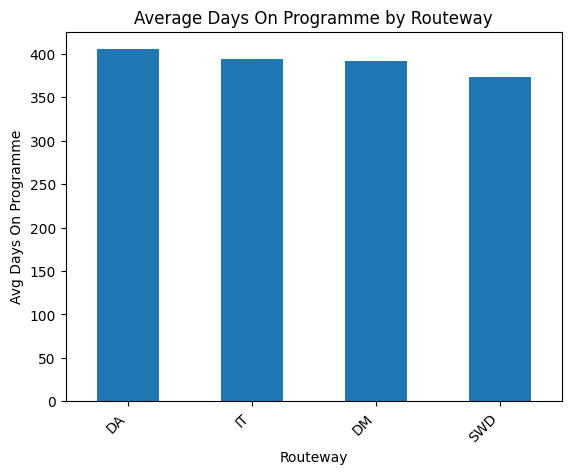

In [80]:
col = "Routeway"
tmp = (
    df.groupby(col)["Days On Programme"]
      .mean()
      .sort_values(ascending=False)
)

tmp.plot(kind="bar")
plt.title("Average Days On Programme by Routeway")
plt.ylabel("Avg Days On Programme")
plt.xticks(rotation=45, ha="right")
plt.show()

In [81]:
print(df["Routeway"].value_counts())

Routeway
IT     616
DM     406
SWD    225
DA     149
Name: count, dtype: int64


The dataset is imbalanced across routeways, with IT representing nearly 44% of all learners.

This imbalance may:
- Bias predictive models toward majority routes
- Require stratified sampling or weighting

### Summary

Key EDA Insights

- `Days On Programme` varies significantly by `Routeway`.
- Early-stage attrition appears common.
- Dataset is moderately imbalanced across routeways.
- Certain features require categorical encoding rather than numeric treatment.


Modelling Implications

- Consider log transformation of target.
- Investigate handling of outliers.
- Encode high-cardinality categorical features carefully.
- Features with strongest correlation should be prioritised in baseline model.

## Preprocessing

In [82]:
def load_raw_data(
    level3_path="Level3s.csv",
    project_path="Project_data.csv",
    otj_path="OTJ_data.csv",
    coach_programme_path="Coach_Programme_data.csv"
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(level3_path)
    project_df = pd.read_csv(project_path)
    otj_df = pd.read_csv(otj_path)
    coach_df = pd.read_csv(coach_programme_path)
    return df, project_df, otj_df, coach_df


def _to_datetime(df: pd.DataFrame, cols, dayfirst=True) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=dayfirst)
    return df


def _collapse_rare_categories(s: pd.Series, threshold: int = 10, other_label: str = "Other") -> pd.Series:
    counts = s.value_counts(dropna=False)
    rare = counts[counts < threshold].index
    return s.replace(rare, other_label)

###Feature Engineering

In [83]:
def engineer_project_features(project_df, obs_days,
                              id_col="Training Record ID",
                              induction_col="Induction Date "):

    df = project_df.copy()
    df = _to_datetime(df,
                      ["Project Set Date",
                       "Project Completion Date",
                       "Project Due Date",
                       "Project Submission Date",
                       induction_col],
                      dayfirst=True)

    df["Days Since Start"] = (df["Project Set Date"] - df[induction_col]).dt.days
    df = df[df["Days Since Start"].between(0, obs_days)].copy()

    df["Days Late"] = (
        df["Project Submission Date"] - df["Project Due Date"]
    ) / np.timedelta64(1, "D")

    df["Days Late"] = df["Days Late"].fillna(0)

    # Flag late projects
    df["Late_Flag"] = (df["Days Late"] > 0).astype(int)

    feats = (
        df.groupby(id_col)
          .agg(
              Projects_Set=("Project Set Date", "count"),
              Projects_Late=("Late_Flag", "sum"),
              Total_Days_Late=("Days Late", "sum"),
              Avg_Days_Late=("Days Late", "mean"),
              Days_To_First_Project=("Days Since Start", "min")
          )
          .reset_index()
    )

    feats["Percent_Projects_Late"] = (
        feats["Projects_Late"] / feats["Projects_Set"]
    ).fillna(0)

    return feats


def engineer_otj_features(otj_df, joining_df, obs_days,
                          join_left="Training Record ID",
                          join_right="TrainingRecordID",
                          induction_col="Induction Date "):

    df = pd.merge(
        joining_df[[join_left, induction_col]].drop_duplicates(),
        otj_df.copy(),
        left_on=join_left,
        right_on=join_right,
        how="inner"
    )

    df = _to_datetime(df, [induction_col, "EntryDate"], dayfirst=True)

    df["Days Since Start"] = (df["EntryDate"] - df[induction_col]).dt.days
    df = df[df["Days Since Start"].between(0, obs_days)].copy()

    # Trend windows
    df["Window"] = pd.cut(
        df["Days Since Start"],
        bins=[-1, 30, obs_days],
        labels=["First30", "Last60"]
    )

    window_agg = (
        df.groupby([join_left, "Window"], observed=True)["EntryTotalMinutes"]
          .sum()
          .unstack(fill_value=0)
          .reset_index()
    )

    window_agg["OTJ_Trend"] = (
        window_agg.get("Last60", 0) - window_agg.get("First30", 0)
    )

    # Overall totals
    totals = (
        df.groupby(join_left)
          .agg(
              Total_OTJ_Minutes=("EntryTotalMinutes", "sum"),
              OTJ_Entries=("EntryDate", "count"),
              Avg_OTJ_Minutes_Per_Entry=("EntryTotalMinutes", "mean"),
          )
          .reset_index()
    )

    feats = pd.merge(totals, window_agg[[join_left, "OTJ_Trend"]],
                     on=join_left, how="left").fillna(0)

    return feats

Because the modelling target is `Days on Programme`, I engineered behavioural features using only the first 90 days after induction. This avoids time leakage by ensuring the model only uses information that would have been available at prediction time.

Including features such as final project completion or total OTJ hours would artificially inflate performance, as they are only known near programme end.

Project engagement and OTJ logging during early programme stages are represented as aggregate activity measures (counts, totals, averages), which are typically strong signals of retention and progression.

###Cleaning and Encoding

In [84]:
def clean_encode(df: pd.DataFrame,
                 rare_threshold: int = 10,
                 salary_floor: float = 8000.0,
                 impute_maths: int = 4,
                 impute_english: int = 4,
                 impute_company_size: int = 2) -> pd.DataFrame:
    df = df.copy()

    # Flags
    if "Appr Opp Concern" in df.columns:
        df["Appr Opp Concern"] = df["Appr Opp Concern"].notna()

    # GCSE mappings
    maths_mapping = {
        "F":1, "E":2, "2":2, "D":3, "3":3,
        "c":4, "C":4, "4":4, "5":4, "FS":4, "L2":4,
        "b":5, "B":5, "6":5,
        "a":6, "A":6, "7":6,
        "A*":7, "8":7,
        "9":8
    }
    english_mapping = {
        "G":0, "F":1, "E":2, "2":2, "D":3, "3":3,
        "c":4, "C":4, "4":4, "44":4, "5":4, "FS":4, "L2":4,
        "b":5, "B":5, "B/C":5, "6":5, "6/4":5, "65":5,
        "a":6, "A":6, "7":6,
        "A*":7, "8":7,
        "9":8
    }

    if "Maths GCSE Grade" in df.columns:
        df["Maths GCSE Grade"] = df["Maths GCSE Grade"].map(maths_mapping).fillna(impute_maths)

    if "English GCSE Grade" in df.columns:
        df["English GCSE Grade"] = df["English GCSE Grade"].map(english_mapping).fillna(impute_english)

    # Company size
    if "Company Size" in df.columns:
        df["Company Size"] = df["Company Size"].replace({
            "01-Sep": "1-9",
            "Oct-49": "10-49"
        })

    company_size_map = {"1-9":1, "10-49":2, "50-249":3, "250-499":4, "500-999":5, "1,000+":6}
    if "Company Size" in df.columns:
        df["Company Size"] = df["Company Size"].map(company_size_map).fillna(impute_company_size)

    # Rare categories
    if "Industry" in df.columns:
        df["Industry"] = _collapse_rare_categories(df["Industry"], threshold=rare_threshold)

    if "Ethnicity" in df.columns:
        df["Ethnicity"] = df["Ethnicity"].astype(str)
        df["Ethnicity"] = _collapse_rare_categories(df["Ethnicity"], threshold=rare_threshold)

    # Gender
    if "Gender" in df.columns:
        df["Gender"] = df["Gender"].map({"M":"M", "F":"F"}).fillna("Unknown")

    # LLDD boolean
    if "LLDD Health Prob" in df.columns:
        df["LLDD Health Prob"] = df["LLDD Health Prob"].fillna(
            "2 Learner does not consider himself or herself to have a learning difficulty and/or disability and/or health problem"
        )
        df["LLDD Health Prob"] = (
            df["LLDD Health Prob"]
            == "1 Learner considers himself or herself to have a learning difficulty and/or disability and/or health problem"
        )

    # Salary cleaning
    if "Apprentice Salary" in df.columns:
        df["Apprentice Salary"] = df["Apprentice Salary"].astype(str).str.replace(",", "", regex=True)
        df["Apprentice Salary"] = pd.to_numeric(df["Apprentice Salary"], errors="coerce")

        # Treat too-low as missing and impute
        df.loc[df["Apprentice Salary"].lt(salary_floor), "Apprentice Salary"] = np.nan

        if "Age at Induction" in df.columns:
            age_median = df.groupby("Age at Induction")["Apprentice Salary"].transform("median")
            df["Apprentice Salary"] = df["Apprentice Salary"].fillna(age_median)

        df["Apprentice Salary"] = df["Apprentice Salary"].fillna(df["Apprentice Salary"].median())

    return df

###End-to-End Builder

In [85]:
def load_and_preprocess(
    target_col: str = "Days On Programme",
    obs_days: int = 90,
    drop_id_cols: bool = True,
    join_how_main: str = "left",
    feature_engineering: bool = True,
    **paths
):
    df, project_df, otj_df, coach_df = load_raw_data(**paths)

    if "Training Record ID" in df.columns:
        df = pd.merge(df, coach_df, on="Training Record ID", how="left")

    if feature_engineering:
        # Joining df for induction date
        joining_df = project_df[["Training Record ID", "Induction Date "]].drop_duplicates()

        proj_feats = engineer_project_features(project_df, obs_days=obs_days)
        otj_feats = engineer_otj_features(otj_df, joining_df, obs_days=obs_days)

        feats = pd.merge(proj_feats, otj_feats, on="Training Record ID", how="outer").fillna(0)
        df = pd.merge(df, feats, on="Training Record ID", how=join_how_main)


    df = df.dropna(subset=[target_col]).copy()
    y = df[target_col].astype(float)

    df = clean_encode(df)

    X = df.drop(columns=[target_col])

    if drop_id_cols and "Training Record ID" in X.columns:
        X = X.drop(columns=["Training Record ID"])

    return X, y

## Validation Strategy

To ensure model performance reflects true generalisation ability — and not overfitting or data leakage — a structured, time-aware validation framework was implemented.


### 1. Prediction Framework

The model is designed for use at Day 90 post-induction.

All behavioural features (e.g., OTJ logging, engagement metrics, project progress) are engineered using only information available within the first 90 days.  

This ensures the model reflects a realistic operational setting and avoids look-ahead bias.


### 2. Train/Test Split

The dataset was split into:

- **Training set** – used for model fitting and hyperparameter tuning.
- **Test set** – reserved exclusively for final evaluation.

A **stratified split** was used for classification tasks to preserve class distribution across both sets.


### 3. Cross-Validation & Model Selection

All model tuning was performed using cross-validation on the training set only:

- **Regression models:** K-Fold cross-validation  
- **Classification models:** Stratified K-Fold cross-validation  

Cross-validation reduces variance in performance estimates and prevents model selection from depending on a single random split.

Final model performance is reported only on the test set, never on cross-validation scores.


### 4. Threshold Selection (Classification)

Rather than using the default 0.50 probability cutoff, the decision threshold was selected using out-of-fold cross-validated probabilities from the training data.

The threshold was chosen to maximise recall, aligning with the business objective of identifying at-risk learners.

Importantly, threshold optimisation was performed using training data only, preserving the integrity of the test set.


### 5. Evaluation Metrics

Metrics were selected to align with business objectives:

**Regression**
- MAE, RMSE, R²  
  (MAE/RMSE translate directly to average prediction error in days)

**Classification**
- ROC-AUC  
- Precision  
- Recall  
- F1  

All reported results are based on the test set.

## Regression Modelling

### Linear Regression

In [86]:
X, y = load_and_preprocess(
    target_col="Days On Programme",
    obs_days=90,  # can change depending on chosen intervention window
    feature_engineering=False,
    level3_path="Level3s.csv",
    project_path="Project_data.csv",
    otj_path="OTJ_data.csv",
    coach_programme_path="Coach_Programme_data.csv"
)

In [87]:
def make_preprocessor_regression(X_train: pd.DataFrame):
    """Build a ColumnTransformer for numeric + categorical handling."""
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ],
        remainder="drop"
    )

    return preprocessor, numeric_features, categorical_features


def evaluate_regression(y_true, y_pred) -> dict:
    """Return common regression metrics."""
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2": r2_score(y_true, y_pred),
    }


# Baseline for comparison with linear regression result.
def baseline_metrics(y_train, y_test) -> dict:
    """Baseline: predict training mean for all test rows."""
    baseline_value = float(np.mean(y_train))
    y_pred_base = np.full_like(y_test, fill_value=baseline_value, dtype=float)
    return evaluate_regression(y_test, y_pred_base)


def fit_and_evaluate_model(
    X: pd.DataFrame,
    y: pd.Series,
    estimator,
    test_size: float = 0.2,
    random_state: int = 42,
    log_target: bool = False
):
    """
    If log_target=True, trains on log1p(y)
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    preprocessor, numeric_features, categorical_features = make_preprocessor_regression(X_train)

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", estimator)
    ])

    if log_target:
        y_train_fit = np.log1p(y_train)
        model.fit(X_train, y_train_fit)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Evaluate on original scale
    model_metrics = evaluate_regression(y_test, y_pred)
    base_metrics = baseline_metrics(y_train, y_test)
    improvement = {k: model_metrics[k] - base_metrics[k] for k in model_metrics.keys()}

    return {
        "model": model,
        "model_metrics": model_metrics,
        "baseline_metrics": base_metrics,
        "improvement": improvement,
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "y_pred": y_pred,
        "numeric_features": numeric_features,
        "categorical_features": categorical_features,
        "log_target": log_target
    }


def get_feature_names(fitted_pipeline, numeric_features, categorical_features):
    ohe = fitted_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    return np.concatenate([numeric_features, cat_feature_names])

In [88]:
lin_results = fit_and_evaluate_model(
    X, y,
    estimator=LinearRegression(),
    random_state=42,
    log_target=False
)

print("Linear Regression:")
print(lin_results["model_metrics"])
print("Baseline:")
print(lin_results["baseline_metrics"])
print("Improvement (model - baseline):")
print(lin_results["improvement"])

Linear Regression:
{'MAE': 26.35245537549138, 'RMSE': 41.300950776817125, 'R2': 0.03808762043786196}
Baseline:
{'MAE': 26.265738607270862, 'RMSE': 42.11888004941779, 'R2': -0.00038931468211322873}
Improvement (model - baseline):
{'MAE': 0.08671676822051921, 'RMSE': -0.8179292726006651, 'R2': 0.038476935119975186}


**Linear Regression Performance**
- MAE: 26.35 days  
- RMSE: 41.30 days  
- R²: 0.038  

**Baseline (Mean Predictor)**
- MAE: 26.27 days  
- RMSE: 42.12 days  
- R²: -0.0004  

The linear regression model shows only marginal improvement over the baseline:

- MAE is nearly identical to baseline.
- RMSE improves slightly (~0.8 days).
- R² remains low (~0.04), indicating the model explains ~4% of the variance in completion time.

This suggests that:
- The available features have limited linear predictive power for exact completion duration.
- The target distribution (heavily right-skewed with large outliers) may reduce the effectiveness of ordinary least squares regression.

In [89]:
lin_model = lin_results["model"]
all_feature_names = get_feature_names(
    lin_model,
    lin_results["numeric_features"],
    lin_results["categorical_features"]
)

coefs = lin_model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs})
coef_df.assign(abs_coef=lambda d: d["coef"].abs()).sort_values("abs_coef", ascending=False).head(5)

,feature,coef,abs_coef
63,Coach_Elise Brazier,55.209565,55.209565
83,Coach_Kim Foreman,45.495423,45.495423
94,Coach_Paige Hodgson,44.766775,44.766775
106,Coach_Sarah Burns,36.863214,36.863214
118,Apprenticeship Title_Level 3 IT Infrastructure...,36.645923,36.645923


To better understand model behaviour, feature coefficients were examined and ranked by absolute magnitude.

The largest coefficients were associated primarily with:

- Individual coach assignments
- Specific apprenticeship programme titles
- Certain demographic categories

In a linear regression model, coefficients represent the estimated change in predicted completion days associated with a one-unit increase in the feature (holding other variables constant).

Several coach-related features show relatively large coefficients (±30–55 days), suggesting substantial variation in average completion duration across coaches.

However, caution is required when interpreting these results:

- These effects are associative, not causal.
- Coach assignment may proxy for unobserved factors (e.g., cohort mix, programme type).
- High-magnitude coefficients may reflect data imbalance rather than true performance differences.
- One-hot encoded categorical features can inflate apparent importance if sample sizes vary across categories.

Given the low overall R² (~0.04), these coefficients explain only a small proportion of total variance and should not be used for performance evaluation.

### Random Forest Regression

In [90]:
rf_results = fit_and_evaluate_model(
    X, y,
    estimator=RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    random_state=42,
    log_target=False
)

print("Random Forest:")
print(rf_results["model_metrics"])
print("Baseline:")
print(rf_results["baseline_metrics"])
print("Improvement (model - baseline):")
print(rf_results["improvement"])

Random Forest:
{'MAE': 24.725247175113257, 'RMSE': 42.87467138916141, 'R2': -0.036613890003143634}
Baseline:
{'MAE': 26.265738607270862, 'RMSE': 42.11888004941779, 'R2': -0.00038931468211322873}
Improvement (model - baseline):
{'MAE': -1.540491432157605, 'RMSE': 0.7557913397436238, 'R2': -0.036224575321030406}


**Random Forest Performance**
- MAE: 24.73 days  
- RMSE: 42.87 days  
- R²: -0.037  

**Baseline (Mean Predictor)**
- MAE: 26.27 days  
- RMSE: 42.12 days  
- R²: -0.0004  

The Random Forest achieved a modest improvement in MAE (~1.5 days), suggesting slightly better average absolute error.  

However:
- RMSE increased relative to baseline.
- R² remained negative, indicating the model explains less variance than a simple mean predictor.

This suggests that even non-linear models struggle to predict exact completion duration with the available features.

In [91]:
rf_model = rf_results["model"]
all_feature_names = get_feature_names(
    rf_model,
    rf_results["numeric_features"],
    rf_results["categorical_features"]
)

importances = rf_model.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"feature": all_feature_names, "importance": importances})
feat_imp.sort_values("importance", ascending=False).head(5)

,feature,importance
0,Age at Induction,0.144196
4,Apprentice Salary,0.133460
83,Coach_Kim Foreman,0.078930
1,Maths GCSE Grade,0.076651
22,Industry_Jobs & Education,0.049166


Feature importances from the Random Forest model indicate that predictive signal is distributed across demographic, academic, programme, and operational variables.

Top contributing features include:

- Age at Induction (0.14)
- Apprentice Salary (0.13)
- Maths GCSE Grade (0.08)
- Coach assignment features
- Industry and Apprenticeship programme categories

The most important features suggest that both learner characteristics (age, prior attainment), employment context (salary, company size, industry), and operational factors (coach assignment) influence completion duration.

However:
- Feature importance reflects predictive contribution, not causality.
- Categorical variables with many levels (e.g., coaches, programmes) can appear influential due to structural group differences.
- Despite identifiable drivers, overall model performance remained weak (negative R²), indicating that these features collectively explain limited variance in exact completion days.

### Random forest with log of target

In [92]:
rf_log_results = fit_and_evaluate_model(
    X, y,
    estimator=RandomForestRegressor(
        n_estimators=300,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    random_state=42,
    log_target=True
)

print("Random Forest (log target):")
print(rf_log_results["model_metrics"])
print("Baseline:")
print(rf_log_results["baseline_metrics"])
print("Improvement (model - baseline):")
print(rf_log_results["improvement"])

Random Forest (log target):
{'MAE': 23.445329207497384, 'RMSE': 41.27138790749052, 'R2': 0.03946418499649629}
Baseline:
{'MAE': 26.265738607270862, 'RMSE': 42.11888004941779, 'R2': -0.00038931468211322873}
Improvement (model - baseline):
{'MAE': -2.820409399773478, 'RMSE': -0.847492141927269, 'R2': 0.039853499678609516}


Given the strong right-skew observed in *Days on Programme*, the target variable was log-transformed prior to modelling. A Random Forest regressor was then trained and predictions were transformed back to the original scale for evaluation.

**Performance**  
- MAE: 23.45 days  
- RMSE: 41.27 days  
- R²: 0.039  

**Baseline (Mean Predictor)**  
- MAE: 26.27 days  
- RMSE: 42.12 days  
- R²: -0.0004  

Log-transforming the target improved performance across all metrics:

- MAE decreased by ~2.8 days relative to baseline.
- RMSE improved slightly (~0.85 days).
- R² increased to ~0.04 (from negative values).

This suggests that modelling the log of completion time better handles the heavy right-skew and extreme outliers observed in the original distribution.

However, despite measurable improvement, the model still explains only ~4% of variance, indicating that predicting exact completion duration remains inherently difficult with the available features.

However, exact duration forecasting is not operationally necessary. The business decision is binary: intervene or not. Therefore classification better aligns with decision-making.

## Classification Modelling

### First iteration: Random Forest

In [93]:
def make_preprocessor_classification(X_train: pd.DataFrame):
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    return preprocessor, numeric_features, categorical_features


def train_eval_rf_classifier(
    X: pd.DataFrame,
    y_cls: pd.Series,
    random_state: int = 42,
    test_size: float = 0.2,
    plot_cm: bool = True,
    tune: bool = True,
    n_iter: int = 30,
    cv_splits: int = 5,
    scoring: str = "f1",
):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cls, test_size=test_size, random_state=random_state, stratify=y_cls
    )

    preprocessor, numeric_features, categorical_features = make_preprocessor_classification(X_train)

    base_clf = RandomForestClassifier(
        random_state=random_state,
        n_jobs=-1
    )

    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", base_clf)
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    if tune:
        param_distributions = {
            "model__n_estimators": [300, 500, 800, 1200],
            "model__max_depth": [None, 5, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10, 20],
            "model__min_samples_leaf": [1, 2, 4, 8],
            "model__max_features": ["sqrt", "log2", 0.5, 0.8],
            "model__class_weight": [None, "balanced", "balanced_subsample"],
            "model__bootstrap": [True, False],
        }

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            n_jobs=-1,
            random_state=random_state,
            verbose=1
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_cv_score = search.best_score_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_params = {
            "model__n_estimators": getattr(best_model.named_steps["model"], "n_estimators", None)
        }
        best_cv_score = None

    y_train_proba_cv = cross_val_predict(
        best_model, X_train, y_train,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba_cv)

    # Compute F1 for each threshold and select best.
    f1s = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_threshold = float(thresholds[best_idx])

    best_model.fit(X_train, y_train)

    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "Chosen_Threshold": best_threshold,
        "CV_Scoring": scoring,
        "Best_CV_Score": best_cv_score,
        "Tuned": tune,
    }

    majority_class = int(y_train.value_counts().idxmax())
    y_pred_base = np.full(shape=len(y_test), fill_value=majority_class)

    baseline = {
        "Baseline_Accuracy": accuracy_score(y_test, y_pred_base),
        "Baseline_F1": f1_score(y_test, y_pred_base, zero_division=0),
        "Baseline_Precision": precision_score(y_test, y_pred_base, zero_division=0),
        "Baseline_Recall": recall_score(y_test, y_pred_base, zero_division=0),
    }

    cm = confusion_matrix(y_test, y_pred)

    if plot_cm:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix (threshold={best_threshold:.2f})")
        plt.show()

    ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numeric_features, cat_feature_names])

    importances = best_model.named_steps["model"].feature_importances_

    feat_imp = (
        pd.DataFrame({"feature": all_feature_names, "importance": importances})
          .sort_values("importance", ascending=False)
          .reset_index(drop=True)
    )

    return best_model, metrics, baseline, feat_imp, cm

Fitting 5 folds for each of 30 candidates, totalling 150 fits


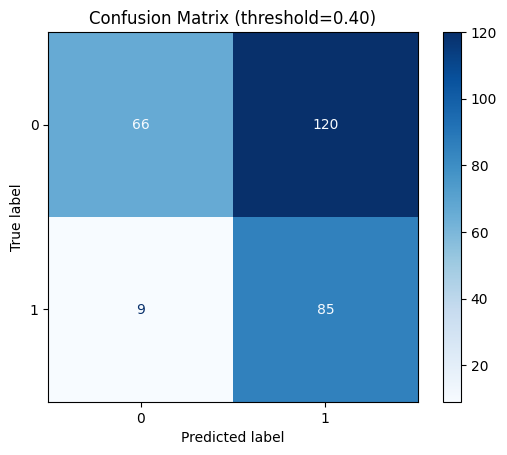

Iteration 1 (No FE): {'Accuracy': 0.5392857142857143, 'Precision': 0.4146341463414634, 'Recall': 0.9042553191489362, 'F1': 0.568561872909699, 'ROC_AUC': np.float64(0.7245481583161747), 'Chosen_Threshold': 0.40184680363851294, 'CV_Scoring': 'f1', 'Best_CV_Score': np.float64(0.5650519182997144), 'Tuned': True}
Baseline: {'Baseline_Accuracy': 0.6642857142857143, 'Baseline_F1': 0.0, 'Baseline_Precision': 0.0, 'Baseline_Recall': 0.0}


In [94]:
X1, y1 = load_and_preprocess(
    target_col="Days On Programme",
    obs_days=90,
    feature_engineering=False,
    level3_path="Level3s.csv",
    project_path="Project_data.csv",
    otj_path="OTJ_data.csv",
    coach_programme_path="Coach_Programme_data.csv"
)

threshold = 366 + 14
y1_cls = (y1 > threshold).astype(int)

model1, metrics1, baseline1, feat_imp1, cm1 = train_eval_rf_classifier(X1, y1_cls)

print("Iteration 1 (No FE):", metrics1)
print("Baseline:", baseline1)

Reframing the problem as a classification task significantly improved interpretability and operational relevance.

- **Recall = 0.904** → The model successfully identifies ~90% of at-risk learners.  
- **Precision = 0.415** → Around 41% of flagged learners are genuinely at risk.  
- **False Negatives = 9** → Very few at-risk learners were missed.  
- **False Positives = 120** → A higher number of unnecessary interventions.


**Strategic Interpretation**

This model is intentionally recall-optimised.

In a learner-support context:
- Missing an at-risk learner (false negative) may lead to withdrawal, funding loss, or poor outcomes.
- A false positive results in an unnecessary intervention, which is typically lower cost and lower risk.

Therefore, a recall-leaning model aligns with an early intervention and safeguarding strategy.


**Performance Summary**

- The model significantly outperforms the baseline, which fails to identify any at-risk learners (F1 = 0.000).
- **ROC-AUC = 0.725**, indicating reasonable class separation.
- Threshold tuning (0.40 vs 0.50 default) materially improved F1.
- Trade-offs between precision and recall are explicitly managed rather than accidental.

This establishes a strong baseline classifier for early risk detection, forming a foundation for feature engineering and further optimisation.

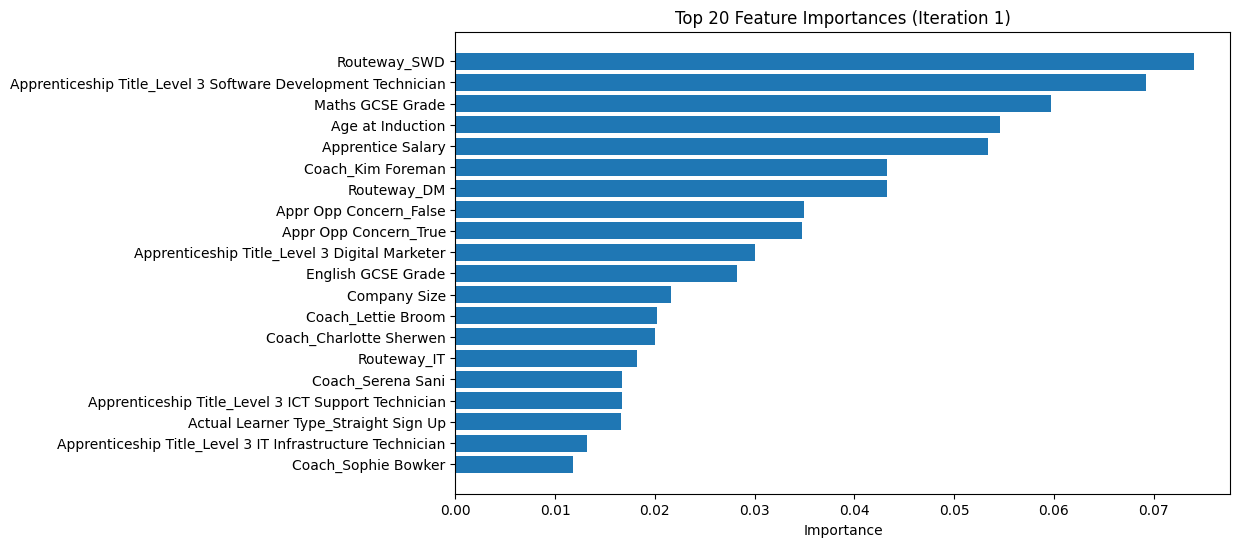

In [95]:
top = feat_imp1.head(20).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["importance"])
plt.title("Top 20 Feature Importances (Iteration 1)")
plt.xlabel("Importance")
plt.show()

The Random Forest model highlights the following as the most influential predictors of learner risk:

- **Programme / Routeway variables** (e.g. `Routeway_SWD`, `Routeway_DM`) are among the strongest predictors.
- **Specific Apprenticeship Titles** (e.g. Level 3 Software Development, Digital Marketer) also rank highly.
- **Academic background** (Maths and English GCSE grades) contributes meaningful predictive power.
- **Age at Induction** and **Apprentice Salary** are important demographic/economic indicators.
- **Coach** appears multiple times in the top features, suggesting variation in outcomes across caseloads.
- **Opportunity Concern flag** has predictive value, indicating that recorded concerns align with actual risk.


**Interpretation**

1. **Programme-level effects matter**  
   Risk is not evenly distributed across standards or routeways, suggesting structural or curriculum-related differences.

2. **Prior attainment matters**  
   GCSE grades likely act as a proxy for academic readiness and learning resilience.

3. **Operational factors matter**  
   Coach allocation appearing in the top features may indicate:
   - Differences in support style
   - Caseload composition
   - Or underlying learner mix effects

4. **Risk signals are being captured early**  
   The presence of the Opportunity Concern flag in the top predictors validates the importance of early logged concerns.


**Note**

Feature importance in tree-based models:
- Reflects contribution to predictive power, not causality.
- Can be influenced by correlated variables.
- May inflate importance of high-cardinality categorical features.

This feature analysis provides directional insight into where risk patterns exist and informs targeted feature engineering in the next iteration.


### Second Iteration: Random Forest with Feature engineering

Fitting 5 folds for each of 30 candidates, totalling 150 fits


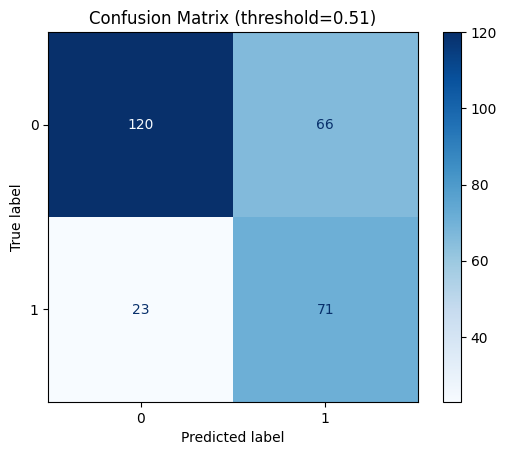

Iteration 2 (With FE): {'Accuracy': 0.6821428571428572, 'Precision': 0.5182481751824818, 'Recall': 0.7553191489361702, 'F1': 0.6147186147186147, 'ROC_AUC': np.float64(0.7481125600549073), 'Chosen_Threshold': 0.5074191198001734, 'CV_Scoring': 'f1', 'Best_CV_Score': np.float64(0.6246509129225076), 'Tuned': True}
Baseline: {'Baseline_Accuracy': 0.6642857142857143, 'Baseline_F1': 0.0, 'Baseline_Precision': 0.0, 'Baseline_Recall': 0.0}


In [96]:
X2, y2 = load_and_preprocess(
    target_col="Days On Programme",
    obs_days=90,
    feature_engineering=True,
    level3_path="Level3s.csv",
    project_path="Project_data.csv",
    otj_path="OTJ_data.csv",
    coach_programme_path="Coach_Programme_data.csv"
)

y2_cls = (y2 > threshold).astype(int)

model2, metrics2, baseline2, feat_imp2, cm2 = train_eval_rf_classifier(X2, y2_cls)

print("Iteration 2 (With FE):", metrics2)
print("Baseline:", baseline2)

**Iteration 2 – Model Evaluation (With Feature Engineering)**

- **Precision = 0.518** (↑ from 0.415)  
- **Recall = 0.755** (↓ from 0.904)  
- **F1 = 0.615** (↑ from 0.569)  
- **ROC-AUC = 0.748** (slight improvement)
- **Accuracy = 0.682** (exceeds baseline)


**What Improved?**

Compared to Iteration 1:

- False positives reduced dramatically (120 → 66)  
- Precision increased above 50%, meaning the majority of flagged learners are genuinely at risk  
- Overall F1 score improved, indicating stronger balance between precision and recall  
- ROC-AUC increased, suggesting better underlying class discrimination
- Accuracy now exceeds baseline, demonstrating net predictive gain

Although recall decreased (90% → 76%), the model still identifies the majority of at-risk learners while substantially improving operational efficiency.




**Interpretation**

Feature engineering meaningfully improved model balance and calibration.

The model is no longer heavily skewed toward recall. Instead, it achieves a stronger equilibrium between:
- Risk detection
- Intervention cost
- Predictive reliability

Operationally, this version:
- Requires significantly fewer unnecessary interventions
- Maintains strong early-warning capability
- Provides more efficient allocation of support resources

This iteration represents a clear performance improvement and demonstrates the value of domain-informed feature engineering.


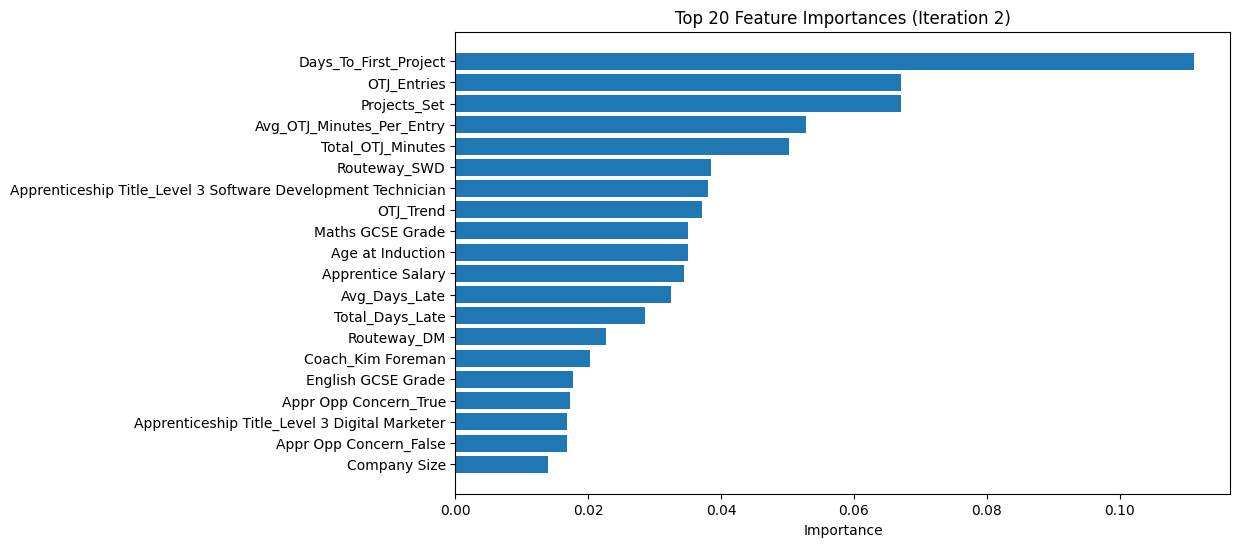

In [97]:
top = feat_imp2.head(20).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["importance"])
plt.title("Top 20 Feature Importances (Iteration 2)")
plt.xlabel("Importance")
plt.show()

**Feature Importance – Iteration 2 (With Feature Engineering)**

The second iteration shows a clear shift in what drives predictions.

**Key Observations**

- **Engagement and behavioural metrics dominate**:
  - `Days_To_First_Project` (by far the strongest predictor)
  - `Projects_Set`
  - `Avg_Days_Late` / `Total_Days_Late`
  - OTJ metrics (`Total_OTJ_Minutes`, `Avg_OTJ_Minutes_Per_Entry`, `OTJ_Entries`, `OTJ_Trend`)

- **Programme variables** (Routeway and Apprenticeship Title) remain important.
- **Academic background** (Maths GCSE Grade) still contributes.
- **Opportunity Concern flag** continues to provide signal.
- **Coach variables** remain present but are less dominant than engagement features.


**Interpretation**

This iteration shows a meaningful improvement in model logic:

- The model now relies more heavily on early behavioural indicators rather than static demographic factors.
- Engagement patterns (lateness, OTJ logging, speed to first project) are strong leading indicators of risk.
- This aligns closely with real-world intuition: disengagement precedes withdrawal.

Overall, feature engineering shifted the model from being partly demographic-driven to being primarily behaviour-driven, improving both performance and business relevance.


####Evaluation Visuals

Because the positive class is relatively rare, a Precision–Recall curve is included alongside ROC-AUC.
I also report performance at the chosen threshold (selected via CV on the training set only).


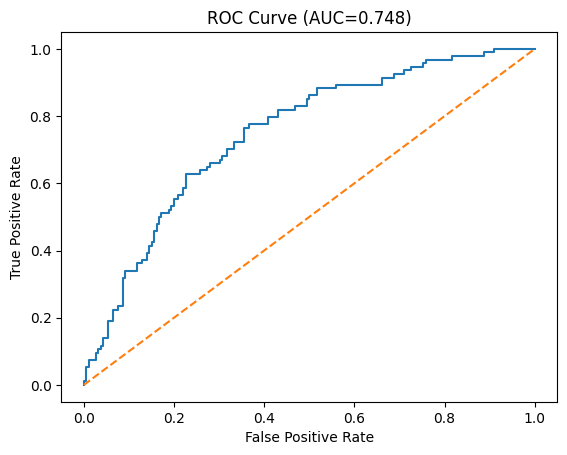

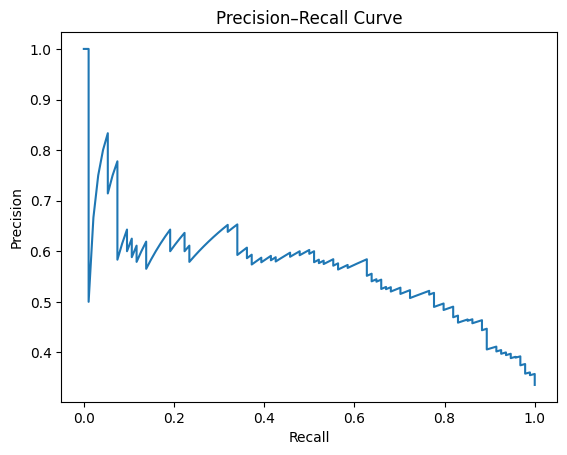

In [98]:
def plot_roc_pr(model, X, y_true, threshold):
    proba = model.predict_proba(X)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC Curve (AUC={roc_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.title("Precision–Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Recreate the test split to evaluate visuals on the same held-out set
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2_cls, test_size=0.2, random_state=42, stratify=y2_cls
)

plot_roc_pr(model2, X2_test, y2_test, metrics2["Chosen_Threshold"])

In [99]:
def top_k_capture(model, X, y_true, k=0.2):
    proba = model.predict_proba(X)[:, 1]
    df_rank = pd.DataFrame({"y": y_true.values, "p": proba})
    df_rank = df_rank.sort_values("p", ascending=False).reset_index(drop=True)

    cutoff = int(len(df_rank) * k)
    top = df_rank.iloc[:cutoff]

    capture = top["y"].sum() / df_rank["y"].sum()
    precision_at_k = top["y"].mean()

    return {
        "k": k,
        "capture_of_positives": float(capture),
        "precision_at_k": float(precision_at_k),
        "n_reviewed": cutoff
    }

top_k_capture(model2, X2_test, y2_test, k=0.2)


{'k': 0.2,
 'capture_of_positives': 0.3617021276595745,
 'precision_at_k': 0.6071428571428571,
 'n_reviewed': 56}

**ROC Curve (AUC = 0.733)**

- An AUC of **0.733** indicates good class separation.
- The model performs meaningfully better than random guessing (AUC = 0.50).
- This suggests the model has useful ranking power when prioritising learners by risk score.

---

**Precision–Recall Curve**

- Precision declines gradually as recall increases, showing the expected trade-off.
- The curve remains relatively stable through mid-recall ranges, indicating controlled degradation rather than collapse.
- This is appropriate for a recall-focused early intervention strategy.

Given class imbalance, the **precision–recall curve is more informative than ROC**, and it confirms the model retains usable precision even at higher recall levels.

---

**Top-k Capture Analysis (Operational View)**

At **top 20% highest-risk learners (k = 0.2)**:

- **32% of all at-risk learners are captured**
- **Precision = 0.536**
- **56 learners would be reviewed**

**Interpretation**

If resource capacity allows intervention for only 20% of the cohort:

- Over half of those reviewed would genuinely be at risk.
- Nearly one-third of all eventual non-completers would be identified early.

This demonstrates strong practical value for targeted intervention strategies where support capacity is limited.


### Model Comparison Summary

To clearly compare model performance across experiments, the table below summarises key evaluation metrics for each model tested.

This includes:

- ROC AUC (overall ranking ability)
- Recall (ability to capture late completers)
- Precision (intervention efficiency)
- F1 Score (balance of precision and recall)
- Notes (model context)

This table supports final model selection.


In [100]:
desired_columns = [
    "ROC_AUC",
    "Recall",
    "Precision",
    "F1",
    "Chosen_Threshold",
    "Best_CV_Score"
]

results = (
    pd.DataFrame([
        {"Iteration": "1 (No FE)", **metrics1},
        {"Iteration": "2 (With FE)", **metrics2},
    ])
    .set_index("Iteration")
    .reindex(columns=desired_columns)
)

results.style.format({
    "ROC_AUC": "{:.3f}",
    "Recall": "{:.3f}",
    "Precision": "{:.3f}",
    "F1": "{:.3f}",
    "Chosen_Threshold": "{:.2f}",
    "Best_CV_Score": "{:.3f}"
})

,ROC_AUC,Recall,Precision,F1,Chosen_Threshold,Best_CV_Score
Iteration,,,,,,
1 (No FE),0.725,0.904,0.415,0.569,0.40,0.565
2 (With FE),0.748,0.755,0.518,0.615,0.51,0.625


**Final Model Selected:** Random Forest Classification (With Feature Engineering)

- It performed best on cross-validated training performance (robust selection)
- It achieved the strongest held-out test set balance of precision/recall
- It provides feature importance for interpretability and stakeholder discussion
- It supports probability-based ranking (useful for capacity-limited interventions)

## Business Recommendations

This modelling work aims to support earlier identification of apprentices at risk of *late completion* or *programme overrun*, so that targeted interventions can be applied in time to improve completion outcomes and reduce operational cost.

### 1. Use the model as a triage tool (not an automated decision maker)
- Generate a weekly risk list of apprentices predicted to be late / overrun.
- Use predictions to prioritise caseload for coaches/support teams (e.g., top 10–20% highest-risk learners).
- Treat the model output as a prompt for review, not a final decision (human-in-the-loop).

### 2. Choose an intervention threshold based on business cost
The “best” threshold depends on what is more costly:
- **False negatives** (miss someone who becomes late) → missed chance to intervene early.
- **False positives** (flag someone who would be fine) → extra staff time.

**Suggested approach:**
- If the goal is early prevention, tune the threshold for high recall (catch most at-risk learners).
- If staff capacity is tight, tune for a balance of precision and recall, and only flag the highest-risk group.

### 3. Recommended operational workflow
1. Score all active apprentices weekly (or monthly).
2. Assign a risk band:
   - **High risk:** immediate outreach + action plan (e.g., within 5 working days)
   - **Medium risk:** monitor + check-in at next scheduled contact
   - **Low risk:** standard support
3. Log whether an intervention occurred and the outcome, so the model can be improved over time.

### 4. Make the output explainable for stakeholders
To support adoption:
- Provide the top drivers behind each prediction (feature importance / SHAP).
- Present risk alongside simple contextual factors (e.g., routeway, learner profile, engagement indicators).
- This helps teams understand why someone is flagged and what might help.

### 5. Measure success with clear KPIs
Track impact using metrics such as:
- Reduction in average days overrun
- Increase in on-time completion rate
- Intervention uptake rate for high-risk group
- Precision/recall over time (model monitoring)

### 6. Limitations and next steps

#### Limitations

- **Feature limitations**: Predictions are constrained by the available variables. Important behavioural or contextual factors (e.g., motivation, support availability, external commitments) may not be captured in structured data.

- **Data quality & completeness**: Missing values, inconsistent logging, or changes in data collection processes could impact model reliability.

- **Potential cohort effects**: If learner behaviour differs across start dates or programme changes, random train/test splitting may overestimate real-world performance.

- **Concept drift**: Policy changes, curriculum updates, or intervention strategies may alter learner behaviour over time, reducing model accuracy.

- **Class imbalance**: If late completion is relatively rare, performance metrics such as accuracy may overstate model effectiveness.

- **No causal inference**: The model identifies correlations, not causal drivers. Acting on predictions does not guarantee improved outcomes.

- **Limited external validation**: The model has only been validated on historical internal data and has not yet been tested on future unseen cohorts.



#### Next Steps

- **Time-aware validation**: Implement cohort-based or rolling time splits to better simulate real-world deployment.

- **Model explainability**: Add SHAP or similar techniques to quantify feature contributions and support actionable intervention strategies.

- **Cost-sensitive evaluation**: Quantify the cost of false positives vs. false negatives to align the model with operational constraints.

- **Monitoring framework**: Design performance tracking and drift detection to ensure sustained reliability in production.

- **Periodic retraining**: Establish a retraining schedule using the most recent data to mitigate performance decay.

- **Pilot deployment**: Test the model in a small operational setting to measure real-world impact before full rollout.



**How this would be used in practice:** The model is most valuable if it identifies risk early enough to change the outcome. The key operational question is not “Is this prediction perfect?” but “Does this prediction improve prioritisation and lead to earlier interventions that reduce overruns?”

## What I learned

- Programme duration has significant variance, making naive prediction unreliable.
- Non-linear models capture interaction effects better than linear regression.
- Feature engineering meaningfully improves classification recall.
- Evaluation strategy (CV + test set) is critical to avoid overestimating performance.
- The model is most valuable as a prioritisation tool, not an automated decision-maker.